Image colorization project :
We train a CNN to take in greyscale images of ... and output their colorful and plausible colorization.

Imports required :

torch

skimage ? only used for rgb - lab parsing. Maybe we can do that ourselves to make some differentiation with the original project?

numpy

matplotlib

PIL ? only used to open images to rgb. We can use another library

In [298]:
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image
from skimage import color
from scipy.ndimage import gaussian_filter

import os
import os.path

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

import pickle

## Load data, augment it, transform it to LAB compute stats on colors

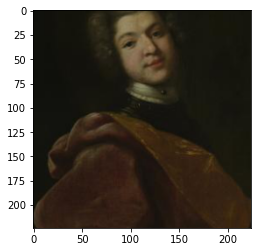

torch.Size([3, 224, 224])


In [300]:
#Data loading
from torchvision import datasets, transforms, utils
from torchvision.datasets import folder, ImageFolder

transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.PILToTensor(),
])

class CustomImageDataset(ImageFolder):
    def __init__(self,root, transform = None,):
        super().__init__(root,transform=transform)

    def __len__(self):
        return super().__len__()

    def __getitem__(self, index: int):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, index

dataset = CustomImageDataset("dataset_updated/training_set/train",transform=transform)
batch_size = 4
loader = data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
print("dataset = ",dataset)
images, indexes = next(iter(loader))


img = images[0]
plt.imshow(transforms.functional.to_pil_image(img))
plt.show()
print(img.shape)
img2 = img.numpy()


#for i, (images, labels) in enumerate(loader, 0):
   #print(images.size())
    #sample_fname, _ = loader.dataset.samples[i]
   # print(sample_fname)


In [ ]:
#LAB transform

def rgb2lab(img):
    #INPUT  RGB image of shape (...,3,H,W)
    #OUTPUT LAB image of shape (...,H,W,3) 

    lab_imgs = color.rgb2lab(img,channel_axis = 0)
    return np.transpose(lab_imgs,(1,2,0))

print(rgb2lab(img2).shape) 
print(rgb2lab(img2)) 

def separateChannels(imageLAB):
    #Input : LAB image with format (H,W,3)
    l = imageLAB[:,:,0]
    a = imageLAB[:,:,1]
    b = imageLAB[:,:,2]
    return l,a,b

l,a,b = separateChannels(rgb2lab(img2))
plt.imshow(l)
plt.show()



### Color stats

In [ ]:
#Color stats (auxiliary functions)

def getDiscretisedColor(a,b,gridSize):
    a = np.round(a/gridSize) * gridSize
    b = np.round(b/gridSize) * gridSize
    return (a,b)

def getMatrixIndex(a,b,gridSize):
    i = (a + 500) / gridSize
    j = (b + 200) / gridSize
    return (int(i),int(j))

def getColorValue(i,j,gridSize):
    a = i * gridSize - 500
    b = j * gridSize - 200
    return (a,b)

def getNNearestNeigbhors(a,b,gridSize): # to improve "getColorDistribution"
    # ... to do
    #return list of (a,b)
    return
    

In [ ]:
#Color stats

# need dataset express like that: list of images (as tensor) with dim H x W x 2 ...
#image_test = rgb2lab(img2) # need to change dim order of color stat code... ?
#images = [np.random.rand(3,3,2) * 100]
#images = [image_test[:][:][1:2]]
#print(image_test.shape)
#print(images[0])

# Initialise the proba distribution of ab pairs in the images dataset (discretised).
gridSize = 10 # too big ?
colorProbabilities = np.zeros((1000 // gridSize, 400 // gridSize))

# Compute the proba distribution of the ab pairs in the images dataset (discretised).
nbOfAnalysedPixels = 0
for data in loader:
    images,_ = data
    for image in images: 
        image = image.numpy()
        image = rgb2lab(image)[:][:][1:2]
        for h in range (image.shape[0]):
            for w in range (image.shape[1]):
                (a,b) = getDiscretisedColor(image[h][w][0],image[h][w][1],gridSize)
                (i,j) = getMatrixIndex(a,b,gridSize)
                colorProbabilities[i][j] += 1
                nbOfAnalysedPixels += 1
colorProbabilities = colorProbabilities / nbOfAnalysedPixels

# Smooth the proba distribution of the ab pairs in the images dataset.
sigma = 5 # gaussian kernel parameter
colorProbabilities = gaussian_filter(colorProbabilities, sigma=sigma) # is it ok ? add a lot of value in gamut... take proba treshold ?
treshold = 0.001 # add treshold if smoothing

# + display distribution in 2d plot ? like in paper (here, very simple)
plt.imshow(colorProbabilities, interpolation='none')
plt.xlim(10, 30) # need to be dynamic !
plt.ylim(40, 70)
plt.show()

# Get the vector of proba of ab pairs that are "in gamut"
inGamutColors = []
inGamutColorsProbas = []
inGamutIndex = {}
currentColorIndex = 0
for i in range (colorProbabilities.shape[0]):
    for j in range (colorProbabilities.shape[1]):
        currentColorPorba = colorProbabilities[i][j]
        if currentColorPorba > treshold: # put a treshold ? if we use smoothing 
            (a,b) = getColorValue(i,j,gridSize)
            inGamutColors.append((a,b))
            inGamutColorsProbas.append(currentColorPorba)
            inGamutIndex[(a,b)] = currentColorIndex
            currentColorIndex += 1
        
Q = len(inGamutColors) 
p_smooth = torch.tensor(inGamutColorsProbas) # + need to normalise ? because treshold
print(Q)
print(inGamutColors)
print(inGamutColorsProbas)
print(inGamutIndex)
#Q = 1 # to remove


### Class rebalancing

In [ ]:
#Define pixel weight vector (class rebalancing)

# Set the parameters (from paper, need empirical value).
lambda_uniform = 1/2 

# Compute a smooth version of the empirical pixel color distribution.
#p_smooth = p # how to do that ? gaussian kernel ? done at previous cell...

# Compute the weight vector.
pixelsWeights = torch.reciprocal((1 - lambda_uniform) * p_smooth + lambda_uniform / Q)

# Normalise the weight vector according to p_smooth (E[W] = 1).
E_W = torch.sum(p_smooth * pixelsWeights)
scale_factor = 1 / E_W
pixelsWeights = scale_factor * pixelsWeights 

print(pixelsWeights)

## Define and instantiate Convolutional NN consistent with the description of the paper. Shown in table 4.

In [ ]:
#NN def

class ColorizationCNN(nn.Module):
    def __init__(self, nb_colour_bins = 313):
        super().__init__()

        self.l_cent = 50.
        self.l_norm = 100.
        self.ab_norm = 110.
        
        channels_block_1 = 64
        channels_block_2 = 128
        channels_block_3 = 256
        channels_block_4 = 512
        channels_block_5 = 512 #dilated
        channels_block_6 = 512 #dilated
        channels_block_7 = 512 
        channels_block_8 = 128 # transpose convolution necessary

        # first conv block : 2 convs. from luminosity image to 64 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock1 = nn.Sequential(nn.Conv2d(1,channels_block_1,(3,3), padding =1), 
                nn.ReLU(True), #inplace for memory efficiency can be used as no skip connections are used.
                nn.Conv2d(channels_block_1,channels_block_1,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_1) #normalization over the 64 channels created
        )

        # second conv block. 2 covs. from 64 features to 128 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock2 = nn.Sequential(nn.Conv2d(64,channels_block_2,(3,3), padding =1,), 
                nn.ReLU(True),
                nn.Conv2d(channels_block_2,channels_block_2,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_2)
        )

        # third conv block. 3 convs. from 64 to 128 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock3 = nn.Sequential(nn.Conv2d(channels_block_2,channels_block_3,(3,3), padding = 1,), 
                nn.ReLU(True),
                nn.Conv2d(channels_block_3,channels_block_3,(3,3), padding =1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_3,channels_block_3,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_3)
        )

        # fourth conv block. 3 convs. from 256 to 512 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock4 = nn.Sequential(nn.Conv2d(channels_block_3,channels_block_4,(3,3), padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_4,channels_block_4,(3,3), padding = 1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_4,channels_block_4,(3,3), padding = 1), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_4)
        )
        
        #fifth conv block. 3 convs. no change in nb feature maps. 3x3 kernels with 2 dilation and 2 padding to not downscale. normalization at the end.

        self.convBlock5 = nn.Sequential(nn.Conv2d(channels_block_4,channels_block_5,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_5,channels_block_5,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_5,channels_block_5,(3,3),dilation=2,padding=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_5)
        )

        #sixth conv block. same as 5
        self.convBlock6 = nn.Sequential(nn.Conv2d(channels_block_5,channels_block_6,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_6,channels_block_6,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_6,channels_block_6,(3,3),dilation=2,padding=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_6)
        )

        #seventh conv block : 3 convs with 3x3 kernels.
        self.convBlock7 = nn.Sequential(nn.Conv2d(channels_block_6,channels_block_7,(3,3),padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_7,channels_block_7,(3,3),padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_7,channels_block_7,(3,3),padding =1,), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_7)
        )

        #eighth conv block : 1 inverse conv to upsample then 2 convs with 3x3 kernels default parameters. Final convolution with 1x1 for classification into a colour bin
        self.convBlock8 = nn.Sequential(nn.ConvTranspose2d(channels_block_7,channels_block_8,(4,4),stride = 2, padding =1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,channels_block_8,(3,3),padding = 1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,channels_block_8,(3,3),padding = 1), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,nb_colour_bins,kernel_size=1) #1x1 kernel for classification in each colour bin (value will be soft maxed for probability)
        )

        self.outputLayer = nn.Conv2d(nb_colour_bins,2,kernel_size=1,dilation=1, bias = False) # 1x1 kernel to get 2 channel values of a and b respectively
    
    def forward(self, luminosity_image):
        h1 = self.convBlock1((luminosity_image-self.l_cent)/self.l_norm) #normalize luminosity to be on scale of 0 to 100
        h2 = self.convBlock2(h1)
        h3 = self.convBlock3(h2)
        h4 = self.convBlock4(h3)
        h5 = self.convBlock5(h4)
        h6 = self.convBlock6(h5)
        h7 = self.convBlock7(h6)
        h8 = self.convBlock8(h7)

        colour_bin_proba = (nn.Softmax(dim=1))(h8)
        '''
        output = self.outputLayer(colour_bin_proba)
        upscaled_output = (nn.Upsample(scale_factor=4, mode='bilinear'))(output) # bilinear upscale to agree with input image size 
        upscaled_output * self.ab_norm # denormalize to cover whole ab value range
        '''
        return colour_bin_proba
        
        

## Define Loss

### Soft encoding

In [ ]:
#Convert a true image Y[BxHxWx2] to pixels color distributions Z[BxHxWxQ] (soft encoding)

# Define a distance measure bewteen two colors (a,b).
colorDistance = lambda c1, c2: np.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)


# Define a Gaussian kernel.
def gaussianKernel(distances):
    sigma = 5
    weights = np.exp(-(distances**2) / sigma)
    return weights


def getColorDistribution(Y,nbOfNeighbors):
    # Initiate a tensor to store the distributions produced from Y.
    Z = torch.zeros(Y.shape[0], Y.shape[1], Y.shape[2], Q)

    # Produce a color distribution for each pixel of the image.
    for i in range (Z.shape[0]):
        print(i)
        for h in range (Z.shape[1]):
            for w in range (Z.shape[2]):
                color_true = Y[i][h][w]
                distances = np.array([colorDistance(color,color_true) for color in inGamutColors]) # not efficient... possible to do better ?
                nearestNeighborsIndexs = (-distances).argsort()[:nbOfNeighbors]
                #nearestNeighborsIndexs = np.argpartition(distances, -nbOfNeighbors)[-nbOfNeighbors:]
                weights = torch.from_numpy(gaussianKernel(distances[nearestNeighborsIndexs]))
                for j in range (weights.shape[0]):
                    Z[i][h][w][nearestNeighborsIndexs[j]] = weights[j]
    
    # Return the produced distributions.
    return Z
    

def getColorDistribution_1hot(Y):
    # Initiate a tensor to store the distributions produced from Y.
    Z = torch.zeros(Y.shape[0], Y.shape[1], Y.shape[2], Q)

    # Produce a color distribution for each pixel of the image.
    for i in range (Z.shape[0]):
        for h in range (Z.shape[1]):
            for w in range (Z.shape[2]):
                color_true = Y[i][h][w]
                a, b = getDiscretisedColor(color_true[0],color_true[1],gridSize)
                gamutIndex = inGamutIndex[(int(a),int(b))] # bug, not always in gamut... due to pooling of Y ?
                Z[i][h][w][gamutIndex] = 1
    
    # Return the produced distributions.
    return Z


### Point estimate

In [ ]:
#Convert the pixel color distributions in Z[HxWxQ] to true picture estimate Y[HxWx2] (point estimate)

# No need to be very efficient because only use when we predict (after training) ? difficult to rewrite with tensor operation

def getPictureEstimate(Z,T):
    # Initiate a tensor to store the image estimated from Z.
    Y_estimate = torch.zeros(Z.shape[0], Z.shape[1], 2)
    
    # Estimate the Lab color for each pixel of the image.
    for h in range (Y_estimate.shape[0]):
        for w in range (Y_estimate.shape[1]):
            # Re-ajust the temperture of the current distribution.
            reajustedDistribution = torch.exp(torch.log10(Z[h][w]) / T)  / torch.sum(torch.exp(torch.log10(Z[h][w]) / T), 2) # check again...

            # Compute the anneled-mean of the current distribution. 
            a, b = 0, 0
            for q in range (Z.shape[2]):
                a += reajustedDistribution[q] * inGamutColors[q][0]
                b += reajustedDistribution[q] * inGamutColors[q][1]
            
            # Estimate the Lab color for the current pixel.
            Y_estimate[h][w][0] = a
            Y_estimate[h][w][1] = b
    
    # Return the estimated picture.
    return Y_estimate

### Loss function

In [ ]:
# Take Z[BxHxWxQ] as input where B is the batch size

#v(Z_hw) weight in paper (section 2)

def getPixelsWeights(Z_batch):
    W = torch.argmax(Z_batch, dim=3)
    for i in range(W.size(dim=0)):
        for h in range(W.size(dim=1)):
            for w in range(W.size(dim=2)):
                W[i,h,w] = pixelsWeights[W[i,h,w]]

    return W

In [ ]:
# Take Z[BxHxWxQ] as input where B is the batch size

#loss function 

def multinomialCrossEntropyLoss(Z_estimate_batch, Z_batch):
    W = getPixelsWeights(Z_batch)
    L = - torch.sum(torch.sum(torch.sum(W * torch.sum(Z_batch * torch.log10(Z_estimate_batch), dim=3), dim=2), dim=1))

    return L

#Loss = multinomialCrossEntropyLoss(torch.rand(4,224,224,Q), torch.rand(4,224,224,Q)) # test
#print(Loss)

## Main training loop and additional function TBD

### Soft encoding (pre computation of the distributions)

In [ ]:
soft_encoded_images = {}

for data in loader:
    images, indexes = data

    #print(indexes.shape[0])

    lab_images = []

    for i in range(images.shape[0]):
        lab_im = rgb2lab(images[i].numpy())
        lab_images.append(lab_im)

    lab_images = torch.tensor(np.array(lab_images))

    downsampler_to_quarter_size = nn.AvgPool2d(4, stride=4)
    downsampled_lab = downsampler_to_quarter_size(torch.permute(lab_images,(0,3,1,2)))
    downsampled_lab = torch.permute(downsampled_lab,(0,2,3,1))

    print(downsampled_lab[:,:,:,1:3].shape)
        
    imagesDistributions = getColorDistribution_1hot(downsampled_lab[:,:,:,1:3])

    for i in range(indexes.shape[0]):
        soft_encoded_images[indexes[i].item()] = imagesDistributions[i][:][:][:].numpy()
        
    

        

In [ ]:
#soft_encoded_images[265]

#a_file = open("soft_encoded_images.pkl", "wb")
#pickle.dump(soft_encoded_images, a_file)
#a_file.close()

a_file = open("soft_encoded_images.pkl", "rb")
soft_encoded_images = pickle.load(a_file)
#print(output)
a_file.close()


Define a trining step: for each image in a batch : prediction, loss, backprop loss

In [ ]:
def training_step(optim,loss_fct,network,dataloader):
    '''
        Function to execute a single training step
            Input : 
                optim = pytorch optimize used for the training step
                loss_fct = loss function used to compare the predicted output to ground truth
                dataloader = pytorch data loader to provide the training data used in the training step

            Output :
                average loss over the training step

    '''
    iteration_losses = []
    #batch_size = 4
    analysed_images = 0

    for data in dataloader:
        images, indexes = data

        lab_images_distributions = []
        l_images = []

        for i in range(images.shape[0]):
            lab_im = rgb2lab(images[i].numpy())
            lab_images_distributions.append(soft_encoded_images[indexes[i].item()]) # get pre-computed distributions (soft encoding)
            #print(soft_encoded_images[indexes[i].item()].shape)
            l_images.append(lab_im[:,:,0])
       

        lab_images_distributions = torch.tensor(np.array(lab_images_distributions)).to("cuda")
        #print(lab_images_distributions.shape)

        l_images = torch.tensor(np.array(l_images))
        l_images = torch.unsqueeze(l_images,dim=1).to("cuda")

        predicted_colour_probability = network.forward(l_images.float())
        predicted_colour_probability = torch.permute(predicted_colour_probability,(0,3,2,1))
        
        loss = loss_fct(predicted_colour_probability, lab_images_distributions)
        iteration_losses.append(loss.item())

        optim.zero_grad() 
        loss.backward()
        optim.step()
        
        analysed_images += batch_size
        print(f"fraction of the dataset analysed: {round(analysed_images/2369 * 100, 2)}%")

    return sum(iteration_losses) / len(iteration_losses) # average loss of training iteration

In [ ]:
colCNN = ColorizationCNN(nb_colour_bins = Q).to("cuda")

initial_lr = 3e-5
optimizer = torch.optim.Adam(colCNN.parameters(),lr = initial_lr , weight_decay=1e-3)

nb_steps = 40
losses = np.zeros(nb_steps)

for step in range(nb_steps):
    print('step :',step)
    losses[step] = training_step(optimizer,multinomialCrossEntropyLoss,colCNN,loader)
    print('current loss :',losses[step])


Plot losses

In [ ]:
x_axis = range(0,nb_steps)
plt.plot(x_axis,losses, label="train loss")

plt.xlabel('number of training steps')
plt.ylabel('avg loss')
plt.title('multinomial cross entropy loss')
plt.legend()
plt.show()

Show the neural network colorization of a specific image vs the real colors of that image

In [303]:
def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()

def show_col_vs_truth(network,data_loader):
    '''
        Function to output figure with one batch of colored images vs its ground truth
        Inputs: 
            -network : Neural network for a*b* channel value predictions
            -data_loader : pytorch data loader to load a batch of images

        Outputs:
            - Figure of colored images vs ground truth
    '''
    with torch.no_grad():
        
        #load RGB images
        images, indexes = next(iter(data_loader))
        batch_size = images.shape[0]

        #get l channel from RGB images
        for i in range(batch_size):
            lab_im = rgb2lab(images[i].numpy())
            lab_images_distributions.append(soft_encoded_images[indexes[i].item()]) # get pre-computed distributions (soft encoding)
            #print(soft_encoded_images[indexes[i].item()].shape)
            l_images.append(lab_im[:,:,0])
       

        lab_images_distributions = torch.tensor(np.array(lab_images_distributions))
        #print(lab_images_distributions.shape)

        #get a tensor of shape (Batch,1,H,W) out of the l images
        l_images = torch.tensor(np.array(l_images))
        l_images = torch.unsqueeze(l_images,dim=1)

        #predictinng the colour bin probability yields tensor of size (B,Q,H,W)
        predicted_colour_probability = network.forward(l_images.float())

        #Permute prediction to get (B,H,W,Q) to later get colour estimate
        predicted_colour_probability = torch.permute(predicted_colour_probability,(0,3,2,1))

        predicted_rgb_images = []
        for i in range(batch_size):
            #get estimate in formate (H,W,2). format (H,W,Q) required
            estimate = getPictureEstimate(predicted_colour_probability[i,:,:,:], 0.38)
            
            #permute estimate to get (2,H,W) format
            estimate = torch.permute(estimate,(2,0,1))

            #fuse predicted channels and light channel
            predicted_lab_image = torch.cat((l_images[i,:,:,:],estimate), dim = 0)

            #convert to RGB and add to list
            predicted_rgb_images.append(color.lab2rgb(predicted_lab_image,channel_axis=0))

        #transform list to tensor
        predicted_rgb_images = torch.tensor(np.asarray(predicted_rgb_images))

        #concatenate all images with ground truth first, then predictions
        images = torch.cat((images,predicted_rgb_images),dim=0)

        #show grid of images
        show_images(utils.make_grid(images,nrow=batch_size))
